In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib.pyplot as plt

##loading the data

In [23]:
data_user = pd.read_csv('user_courses_review_09_2023.csv',on_bad_lines='skip')
data_user.head()
df_clean = data_user.copy()


##cleaning the data

In [24]:
df_clean = df_clean.dropna()
df_clean.isna().sum()

,0
course_name,0
lecture_name,0
review_rating,0
review_comment,0


#Multiclass classification

In [25]:
df_clean['review_rating'] = pd.to_numeric(df_clean['review_rating'], errors='coerce')
mode = df_clean['review_rating'].mode()[0]
df_clean['review_rating'] = df_clean['review_rating'].fillna(mode)
df_clean['review_rating'] = df_clean['review_rating'].astype(int)

##using re module to extract clean text

In [26]:
# Using re module to extract clean data

def clean_text(text):
    text = text.lower()                              # lowercase
    text = re.sub(r'http\S+|www\S+', '', text)       # remove URLs
    text = re.sub(r'\d+', '', text)                  # remove numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)          # remove punctuation & emojis
    text = re.sub(r'\s+', ' ', text)                 # remove extra spaces
    text = text.strip()                              # trim spaces
    return text

df_clean['clean_rating_review'] = df_clean['review_comment'].apply(clean_text)

##dividing into train and test

In [27]:
x = df_clean['clean_rating_review'].astype(str)
y = df_clean['review_rating']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state= 365)

In [28]:
vectorizer = TfidfVectorizer(stop_words= 'english',max_features=5000,
    ngram_range=(1, 2))

In [29]:
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf  = vectorizer.transform(x_test)

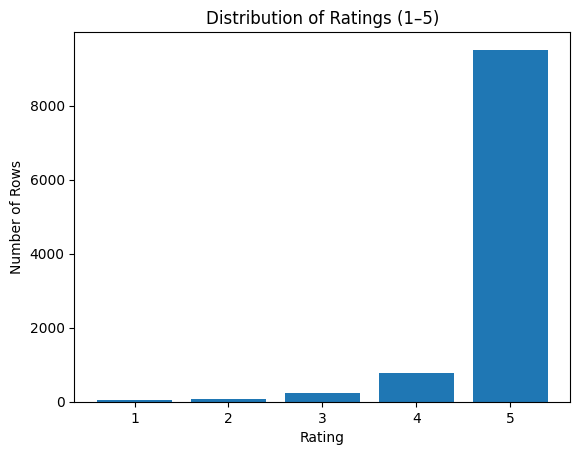

In [30]:
# count how many times each value (1–5) appears
counts = df_clean['review_rating'].value_counts().sort_index()

# plot bar chart
plt.bar(counts.index, counts.values)
plt.xlabel('Rating')
plt.ylabel('Number of Rows')
plt.title('Distribution of Ratings (1–5)')
plt.xticks([1, 2, 3, 4, 5])
plt.show()


## balancing the data

In [31]:
ros = RandomOverSampler(random_state=42)
x_train_resampled, y_train_resampled = ros.fit_resample(x_train_tfidf, y_train)

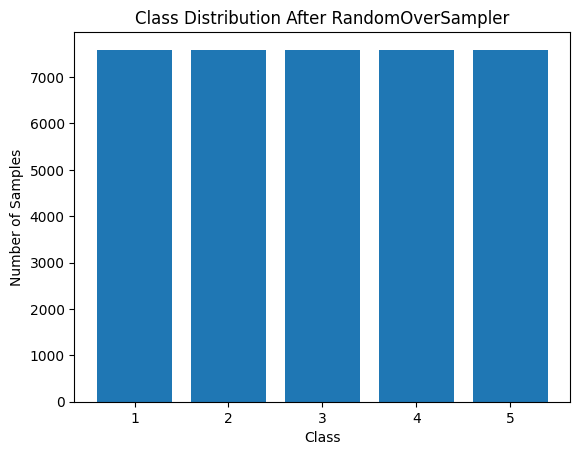

In [32]:


# count class distribution
counts = y_train_resampled.value_counts().sort_index()

plt.bar(counts.index, counts.values)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution After RandomOverSampler")
plt.show()


# using multinomial naive bayes model

In [33]:
nb_model = MultinomialNB(alpha=1.0)
# Retrain
nb_model.fit(x_train_resampled, y_train_resampled)

MultinomialNB()

In [34]:
predictions = nb_model.predict(x_test_tfidf)
predicted_counts = pd.Series(predictions).value_counts()
print(predicted_counts)

5    1475
4     358
3     124
1     105
2      66
Name: count, dtype: int64


###checking accuracy

In [35]:
accuracy = nb_model.score(x_test_tfidf, y_test)
print(f"Model Accuracy on Test Set: {accuracy:.4f}")

Model Accuracy on Test Set: 0.6903


#Binary classification

In [36]:


# Ratings 4–5 → good, Ratings 1–3 → bad
df_clean['type'] = np.where(df_clean['review_rating'] < 4, 'bad', 'good')


In [37]:
x = df_clean['clean_rating_review'].astype(str)
y = df_clean['type']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state= 365)

vectorizer = TfidfVectorizer(stop_words= 'english',max_features=5000,
    ngram_range=(1, 2))

nb_model = MultinomialNB(alpha=1.0)


In [41]:
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf  = vectorizer.transform(x_test)

ros = RandomOverSampler(random_state=42)
x_train_resampled, y_train_resampled = ros.fit_resample(x_train_tfidf, y_train)

nb_model.fit(x_train_resampled, y_train_resampled)
predictions = nb_model.predict(x_test_tfidf)

# Evaluate with classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         bad       0.16      0.77      0.27        66
        good       0.99      0.87      0.93      2062

    accuracy                           0.87      2128
   macro avg       0.58      0.82      0.60      2128
weighted avg       0.97      0.87      0.91      2128



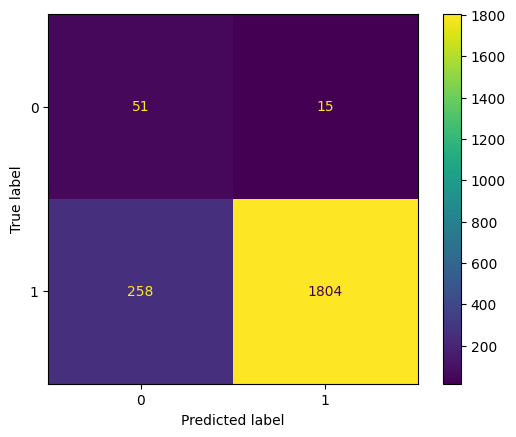

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()


In [40]:
accuracy = nb_model.score(x_test_tfidf, y_test)
print(f"Model Accuracy on Test Set: {accuracy:.4f}")

Model Accuracy on Test Set: 0.8717
